In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qreservoirpy import QReservoir, Layers, utilities

from qiskit.extensions import HamiltonianGate

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 20)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)




In [2]:



n_qubits = 8
SHOTS = 1000
timeseries = [0, 1, 2, 1, 2] * 10
encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
}

H = utilities.random_ising_H(num_qubits=n_qubits, num_terms=160)

placement = {
    0: [0, 1],
    1: [1, 2],
    2: [2, 3],
}



def build_method(circuit, timestep, encoding, reservoir, pos):
        circuit.measure(range(4))
        # circuit.reset(range(4))
        circuit.initialize(encoding[timestep], pos[timestep])
        # circuit.initialize(encoding[timestep], [0, 1])
        # circuit.initialize(encoding[timestep], [2, 3])
        circuit.unitary(reservoir, circuit.qubits)


tvals = np.linspace(0, 10, 100)


In [3]:

experiment_results = []
experiment_methods = []


for exp_id in tqdm(range(len(tvals)), desc="EXPERIMENT"):
    T = tvals[exp_id]

    UT = HamiltonianGate(H, T, label="UT")

    qres = QReservoir(qubits=n_qubits, layers=[
        Layers.Reset(),
        Layers.Timeseries(build_method=build_method,
                        encoding = encoder,
                        reservoir = UT,
                        pos = placement)
    ])

    states = qres.run(
        timeseries=timeseries,
        shots=SHOTS,
        disable_status_bar=True
    )


    WARMUP = 0.1 # 10%
    warmup_idx = int(len(states) * WARMUP)

    xstates = states[:-1][warmup_idx:]
    target = timeseries[1:][warmup_idx:]

    results = np.zeros(len(models))

    N = 100
    for _ in range(N):
        X_train, X_test, y_train, y_test = train_test_split(xstates, target, test_size=1/3)
        for i, model in enumerate(models):
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            results[i] += score

    results /= N

    sorting = np.flip(np.argsort(results))

    experiment_methods.append([models[sorting]])
    experiment_results.append([results[sorting]])


EXPERIMENT:   0%|          | 0/100 [00:00<?, ?it/s]

EXPERIMENT: 100%|██████████| 100/100 [2:24:30<00:00, 86.71s/it]  


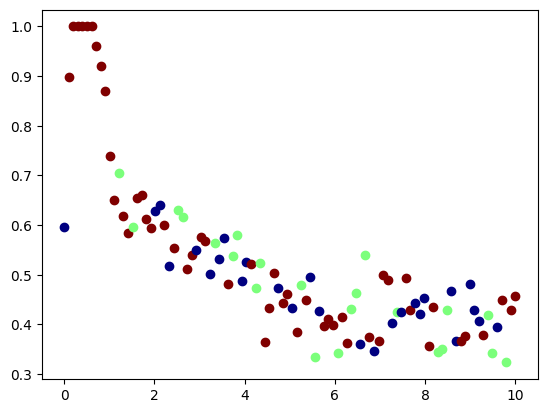

In [17]:
# print(experiment_results)

res = np.array(experiment_results).reshape((len(tvals), -1))
exp = np.array(experiment_methods).reshape((len(experiment_methods), -1))
# plt.plot(tvals, res[:, 0])
# print(exp[:, 0])
cmap = plt.get_cmap('jet', 3)
for t, r, m in zip(tvals, res[:, 0], exp[:, 0]):
    col = -1

    if isinstance(m, RidgeClassifier):
        col = 0
    elif isinstance(m, SVC):
        col = 1
    elif isinstance(m, KNeighborsClassifier):
        col = 2
        
    plt.scatter(t, r, color=cmap(col))

